In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt # plotting
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from math import sqrt
from sklearn.metrics import mean_squared_error

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
WAVE_PATH = "/content/wave.csv"
datas = pd.read_csv(WAVE_PATH,parse_dates=True,index_col=0) 
datas.replace(-99.90, np.nan, inplace=True)
datas = datas.interpolate(limit_direction='both')
datas.index = pd.to_datetime(datas.index).to_period('15T')
datas = datas.rename(columns={'Peak Direction': 'Peak_Direction'})
datas = datas.rename(columns={'SST': 'Temperature'})
datas = datas.rename(columns={'Tz': 'Period'})

In [ ]:
datas.describe()

,Hs,Hmax,Period,Tp,Peak_Direction,Temperature
count,43728.000000,43728.000000,43728.000000,43728.000000,43728.000000,43728.000000
mean,1.238436,2.091178,5.617490,9.005985,98.598678,23.957782
std,0.529151,0.898393,0.928551,2.391658,24.273768,2.232209
min,0.294000,0.510000,3.076000,2.720000,5.000000,19.800000
25%,0.840000,1.410000,4.977000,7.289000,85.000000,21.900000
50%,1.130000,1.910000,5.527000,8.884000,101.000000,23.950000
75%,1.544000,2.600000,6.164000,10.672000,116.000000,26.050000
max,4.257000,7.906000,10.921000,21.121000,358.000000,28.650000


In [ ]:
print(datas.head())
print(datas.shape)
print(datas.columns)


                     Hs  Hmax  Period     Tp  Peak_Direction  Temperature
Date/Time                                                                
2017-01-01 00:00  0.875  1.39   4.421  4.506            49.0        25.65
2017-01-01 00:30  0.875  1.39   4.421  4.506            49.0        25.65
2017-01-01 01:00  0.763  1.15   4.520  5.513            49.0        25.65
2017-01-01 01:30  0.770  1.41   4.582  5.647            75.0        25.50
2017-01-01 02:00  0.747  1.16   4.515  5.083            91.0        25.45
(43728, 6)
Index(['Hs', 'Hmax', 'Period', 'Tp', 'Peak_Direction', 'Temperature'], dtype='object')


In [ ]:
datas

,Hs,Hmax,Period,Tp,Peak_Direction,Temperature
Date/Time,,,,,,
2017-01-01 00:00,0.875,1.39,4.421,4.506,49.0,25.65
2017-01-01 00:30,0.875,1.39,4.421,4.506,49.0,25.65
2017-01-01 01:00,0.763,1.15,4.520,5.513,49.0,25.65
2017-01-01 01:30,0.770,1.41,4.582,5.647,75.0,25.50
2017-01-01 02:00,0.747,1.16,4.515,5.083,91.0,25.45
...,...,...,...,...,...,...
2019-06-30 21:30,2.299,3.60,9.281,12.765,94.0,21.95
2019-06-30 22:00,2.075,3.04,9.303,12.722,95.0,21.95
2019-06-30 22:30,2.157,3.43,9.168,12.890,97.0,21.95


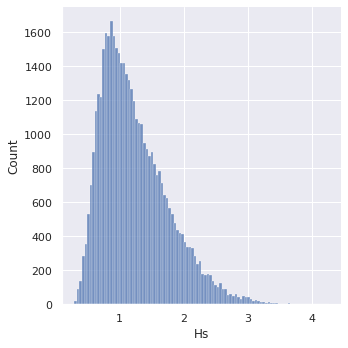

In [ ]:
sns.displot(datas["Hs"])

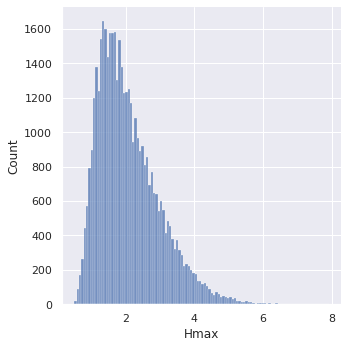

In [ ]:
sns.displot(datas["Hmax"])

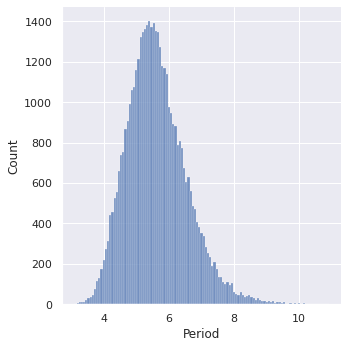

In [ ]:
sns.displot(datas["Period"])

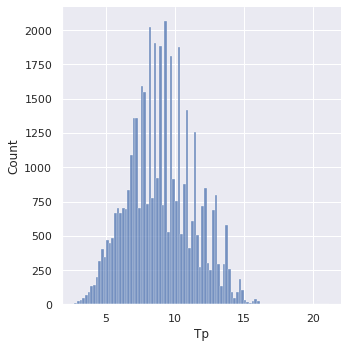

In [ ]:
sns.displot(datas["Tp"])

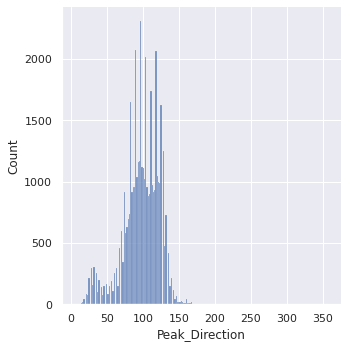

In [ ]:
sns.displot(datas["Peak_Direction"])

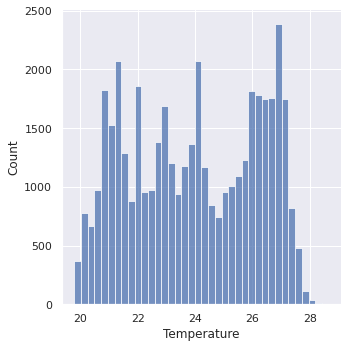

In [ ]:
sns.displot(datas["Temperature"])

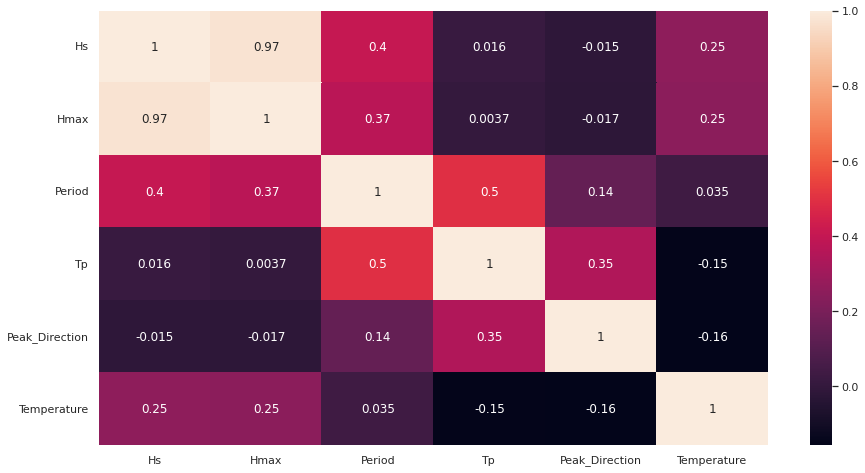

In [ ]:
sns.heatmap(datas.corr(),annot=True)

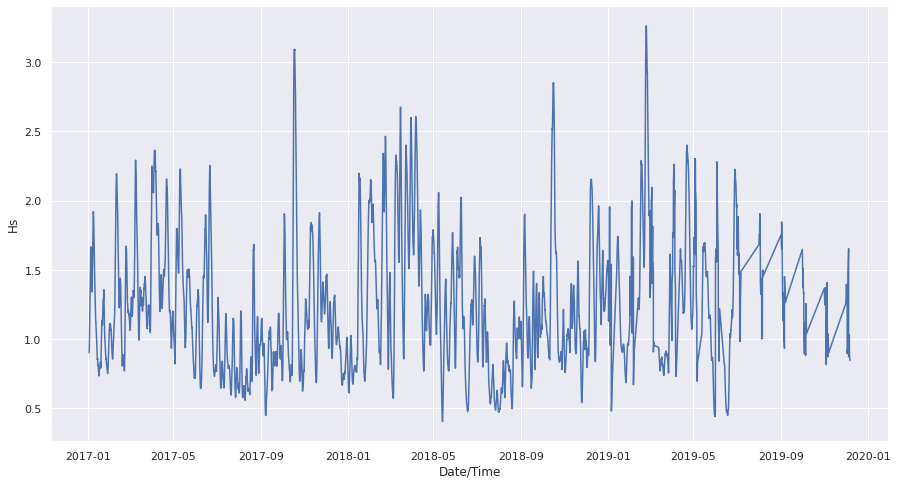

In [ ]:
#remove noise
rolling =  datas.rolling(window=100).mean()
rolling.dropna(inplace=True)
sns.lineplot(data=rolling,x=rolling.index.to_timestamp(),y="Hs")

In [ ]:
train=datas.iloc[:-150,0]
test=datas.iloc[-150:,0]
print(train.shape,test.shape)

(43578,) (150,)


In [ ]:
#Is it stationnary ? 
result=adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
result_diff = adfuller(train.diff().dropna())
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
#if p-value <= 0.05 : NO 

ADF Statistic: -11.634404
p-value: 0.000000
ADF Statistic: -28.392414
p-value: 0.000000


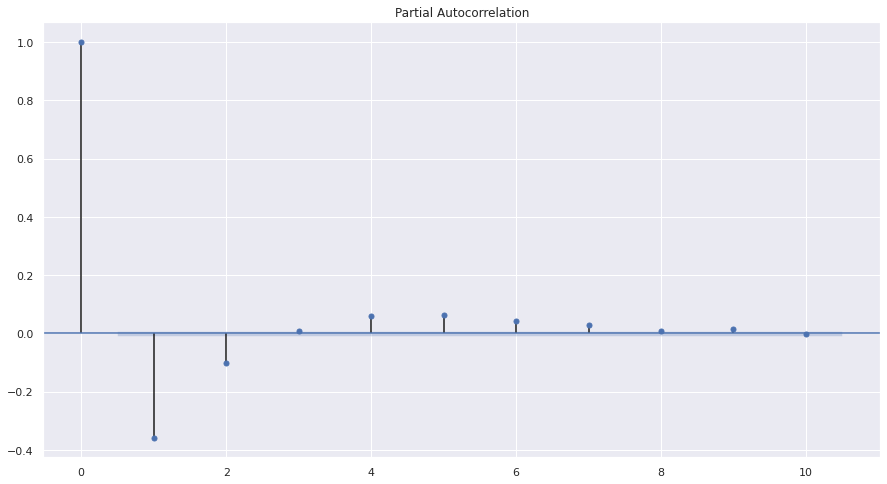

In [ ]:
#p ?
x=plot_pacf((train.diff()).dropna(),lags=10)

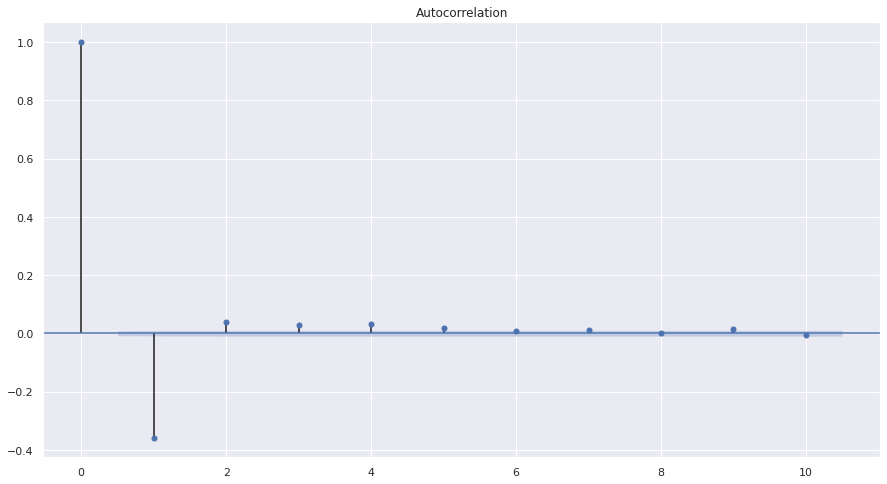

In [ ]:
#q ?
x=plot_acf((train.diff()).dropna(),lags=10)

In [ ]:
model = ARIMA(train, order=(1,0,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                     Hs   No. Observations:                43578
Model:                     ARMA(1, 1)   Log Likelihood               52222.002
Method:                       css-mle   S.D. of innovations              0.073
Date:                Wed, 09 Feb 2022   AIC                        -104436.004
Time:                        15:24:22   BIC                        -104401.275
Sample:                    01-01-2017   HQIC                       -104425.055
                         - 06-27-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2385      0.056     22.046      0.000       1.128       1.349
ar.L1.Hs       0.9960      0.000   2318.228      0.000       0.995       0.997
ma.L1.Hs      -0.3562      0.004    -88.307      0.0

In [ ]:
# summary stats of residuals
print(residuals.describe())

                  0
count  43578.000000
mean       0.000018
std        0.073018
min       -0.651515
25%       -0.039344
50%       -0.002581
75%        0.035912
max        0.606053


In [ ]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))


predicted=2.089797, expected=2.011000
predicted=2.035976, expected=2.253000
predicted=2.171666, expected=2.153000
predicted=2.156011, expected=2.098000
predicted=2.115242, expected=2.082000
predicted=2.090481, expected=2.177000
predicted=2.142447, expected=2.218000
predicted=2.187196, expected=2.045000
predicted=2.092443, expected=2.109000
predicted=2.099636, expected=2.215000
predicted=2.170020, expected=2.141000
predicted=2.147751, expected=1.955000
predicted=2.020812, expected=2.187000
predicted=2.124010, expected=2.370000
predicted=2.277869, expected=2.152000
predicted=2.193223, expected=2.297000
predicted=2.255817, expected=2.341000
predicted=2.306277, expected=2.245000
predicted=2.262851, expected=2.347000
predicted=2.312622, expected=2.257000
predicted=2.272792, expected=2.203000
predicted=2.224051, expected=2.169000
predicted=2.184927, expected=2.044000
predicted=2.091016, expected=2.280000
predicted=2.208507, expected=2.027000
predicted=2.088576, expected=2.168000
predicted=2.

KeyboardInterrupt: ignored

Test RMSE: 0.112


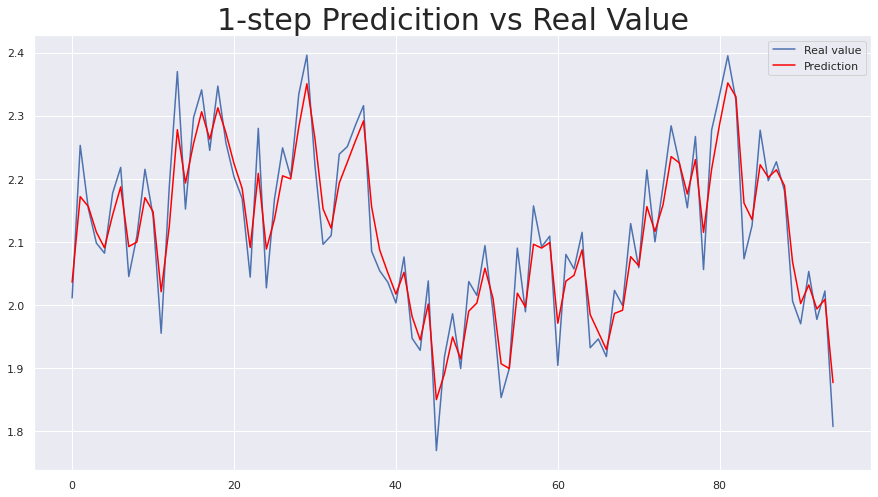

In [ ]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test[:len(predictions)], predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test.values[:len(predictions)-1],label="Real value")
plt.plot(predictions[1:],color='red',label="Prediction")
plt.legend(loc="upper right")
plt.title("1-step Predicition vs Real Value",
          fontsize=30)
plt.show()

In [ ]:
print(model_fit.forecast(steps=48)[0][-1])